# LELEC2910 - Project part I

This notebook serves as a tutorial for the **first part** of the project. It complements the detailed guidelines for the project that are available on Moodle.

In [1]:
# import required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta, datetime
from scipy import fft
from skyfield.api import load, wgs84, EarthSatellite

import utils #utils.py, gathers useful functions for loading and plotting Alphasat measurements

## 1) Load Alphasat measurements 
The cell below loads Alphasat measurements for a chosen month (either 'september2019', 'december2020', 'march2021', 'june2021'). Four months of data are provided, one per season. They do not come from the same year as the Alphasat receiver sometimes suffer from failure events, preventing the use of its data. Hence, the months have been chosen in order to give you data of good quality, i.e., without too many missing days.

In [13]:
# Load Alphasat measurements
month_name: str = 'march2021' #'september2019'#'march2021'#'december2020'#'june2021'
df_ch1, df_ch2, df_ch3, df_ch4 = utils.load_data('data', month_name)

# Print the dataframe associated to channel 2, to show you its content
# print(df_ch2)

## 2) Rain and failure events
The identification of rain events has already been conducted, using visual inspection. Start and end dates of rain events are gathered in the events.csv file, loaded in the cell below. Then, a flag is added to the measurement dataframes, using the following convention: 0 for data under clear sky, 1 for data during a rain event, 2 for a failure of the system.

In [14]:
# Load event file
event_file = 'events.csv'
df_event = pd.read_csv(event_file)

idx: int
last_idx: int = df_event.shape[0]-1
n_error_days: int = 0
event: pd.core.series.Series
_1sec: timedelta = timedelta(seconds=1)

for idx, event in df_event.iterrows():
    event.loc['TIME START'] = pd.to_datetime(event.loc['DATE'], format='%Y-%m-%d') + pd.to_timedelta(event.loc['TIME START'])
    event.loc['TIME STOP'] = pd.to_datetime(event.loc['DATE'], format='%Y-%m-%d') + pd.to_timedelta(event.loc['TIME STOP'])
    event.loc['DURATION'] = pd.to_timedelta(event.loc['DURATION'])

df_event.drop(labels='DATE', axis='columns', inplace=True)

for idx, event in df_event.iterrows():
    if idx == last_idx: continue
    while (df_event.loc[idx+n_error_days, 'TIME STOP'] == df_event.loc[idx+n_error_days+1, 'TIME START'] - _1sec and
           df_event.loc[idx+n_error_days, 'EVENT'] == df_event.loc[idx+n_error_days+1, 'EVENT'] and
           idx+n_error_days < last_idx):
        n_error_days += 1
        if idx+n_error_days == last_idx:
            break
    sum_duration: timedelta = np.sum(df_event.loc[idx:idx+n_error_days, 'DURATION'])
    for i in range(n_error_days):
        df_event.loc[idx+i+1, 'TIME START'] = event.loc['TIME START']
        df_event.loc[idx+i, 'TIME STOP'] = df_event.loc[idx+n_error_days, 'TIME STOP']
        df_event.loc[idx+i, 'DURATION'] = sum_duration + n_error_days*_1sec
        df_event.loc[idx+i+1, 'DURATION'] = sum_duration + n_error_days*_1sec
    n_error_days = 0

df_event.drop_duplicates(inplace=True, ignore_index=True)

# Print the loaded event file to show you its content
# print(df_event[:61]) #september2019
# print(df_event[61:84]) #december2020
# print(df_event[84:104]) #march2021
# print(df_event[104:]) #june2021


In [15]:
# Addition of a flag, based on the recorded events
df_ch1, df_ch2, df_ch3, df_ch4 = utils.add_flags(df_event, df_ch1, df_ch2, df_ch3, df_ch4)

# Print of the second channel dataframe after the flag addition
print(df_ch2['flag'])

time
2021-03-01 00:00:28    0
2021-03-01 00:00:29    0
2021-03-01 00:00:30    0
2021-03-01 00:00:31    0
2021-03-01 00:00:32    0
                      ..
2021-04-01 00:01:21    0
2021-04-01 00:01:22    0
2021-04-01 00:01:23    0
2021-04-01 00:01:24    0
2021-04-01 00:01:25    0
Name: flag, Length: 2678458, dtype: int32


### Plot of loaded data
The cell below plots the loaded data for each day in the selected date range. It uses the plot_one_day_4ch() function defined in utils.py. The last argument of the function is a boolean to set to 'true' to save the figure for each day (in the /figure folder). You are encouraged to run the plots for all dates in the chosen month, and then skim through the saved figures. On each figure, rain events are depicted in red, while failure events are in grey.

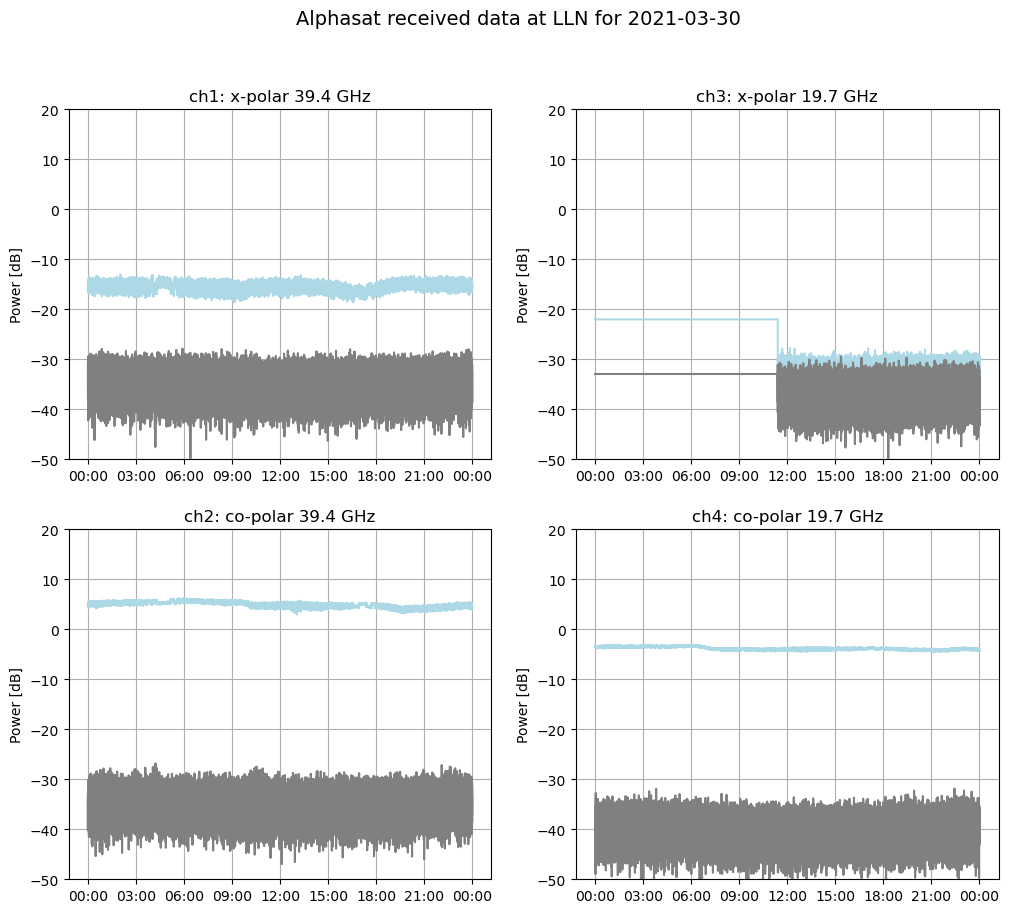

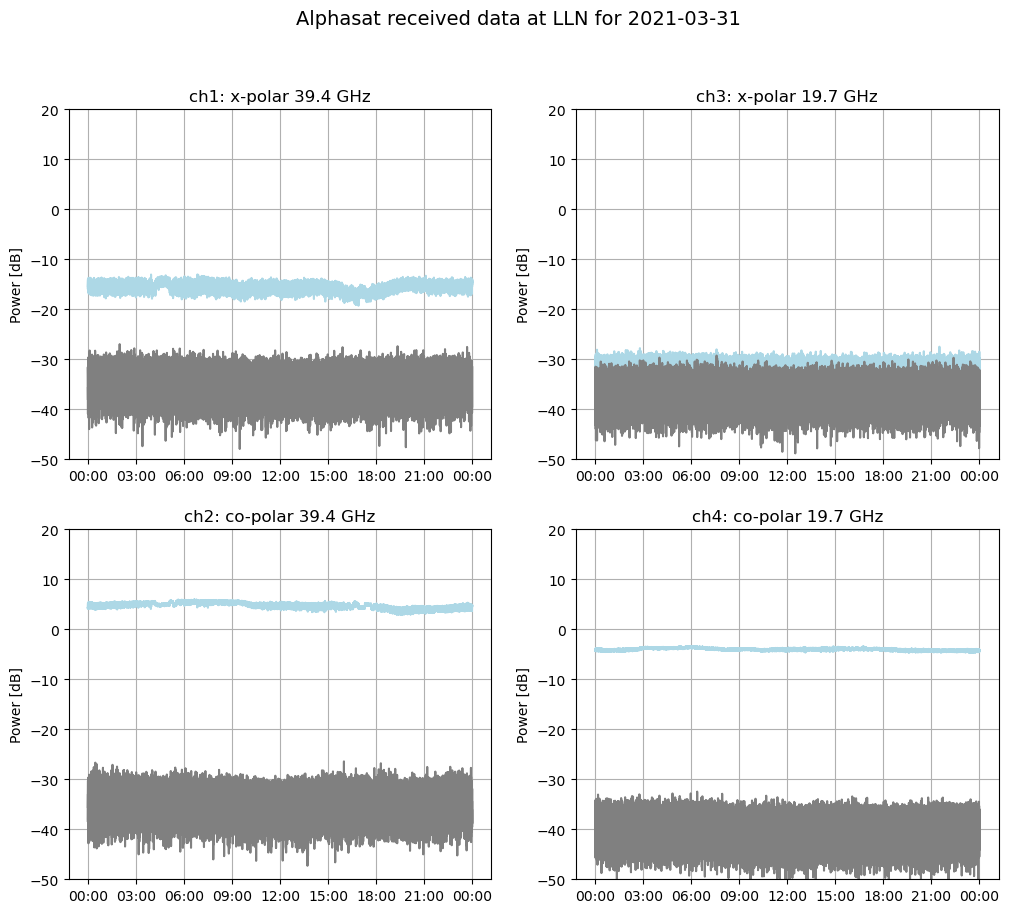

In [18]:
# Choose the start and end dates according to the month
all_dates = pd.date_range(start='2021-03-30', end='2021-03-31')

for date in all_dates:
    utils.plot_one_day_4ch(date, df_ch1, df_ch2, df_ch3, df_ch4, bool_save=True, show=True)

## 3) Excess attenuation and statistics
It is now your turn to process the data and extract the excess attenuation for each month, at each frequency. Start with the excess attenuation time series, and then compute its statistics (CCDF). Remember to first define a template to determine the 0dB level.

**Make sure to remove failure events when you compute the statistics (especially for June 2021).**

In [19]:
# Add S(w), S_filt(w), freqs and signal_filt for each no rain no failure window

freq_filt_param: int = 10_000

for ch in (df_ch1, df_ch2, df_ch3, df_ch4):
    ch['signal_filt'] = np.full_like(ch['signal'], np.nan, dtype=float)
    ch['S(w)'] = np.zeros_like(ch['signal'], dtype=complex)
    ch['S_filt(w)'] = np.zeros_like(ch['signal'], dtype=complex)
    ch['freqs'] = np.zeros_like(ch['signal'], dtype=float)
    
    # Iterate over all events with flag=0, filter the signal with frequency spectrum windowing
    for idx in range(len(df_event)+1):
        idx_slice: pd.core.series.Series = ch['ind_event'] == idx
        x: np.ndarray[float] = ch.loc[idx_slice, 'signal'].array
        if len(x) == 0: continue
        extend_len: int = np.minimum(len(x), freq_filt_param)
        longer_x = np.concatenate((x[::-1][-extend_len:], x, x[::-1][:extend_len]))
        l: int = len(longer_x)
        X: np.ndarray[float] = fft.fft(longer_x, norm='forward')
        half_win_width: int = l//freq_filt_param+1
        window: np.ndarray[float] = np.zeros(l, dtype=float)
        window[:half_win_width] = 1.0
        window[len(window)-(half_win_width-1):] = 1.0
        X_filt: np.ndarray[float] = X*window
        ch.loc[idx_slice, 'signal_filt'] = np.real(fft.ifft(X_filt, norm='forward'))[extend_len:-extend_len]

    # Interpolate over invalid sequences
    
    ch.loc[:, 'signal_filt'] = ch.loc[:, 'signal_filt'].interpolate(method='linear', limit_direction='both')

In [33]:
print(type(df_ch1.loc[:, 'flag'][-1]))

<class 'numpy.int32'>


C:\Users\gauti\AppData\Local\Temp\ipykernel_11240\1659035822.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(df_ch1.loc[:, 'flag'][-1]))


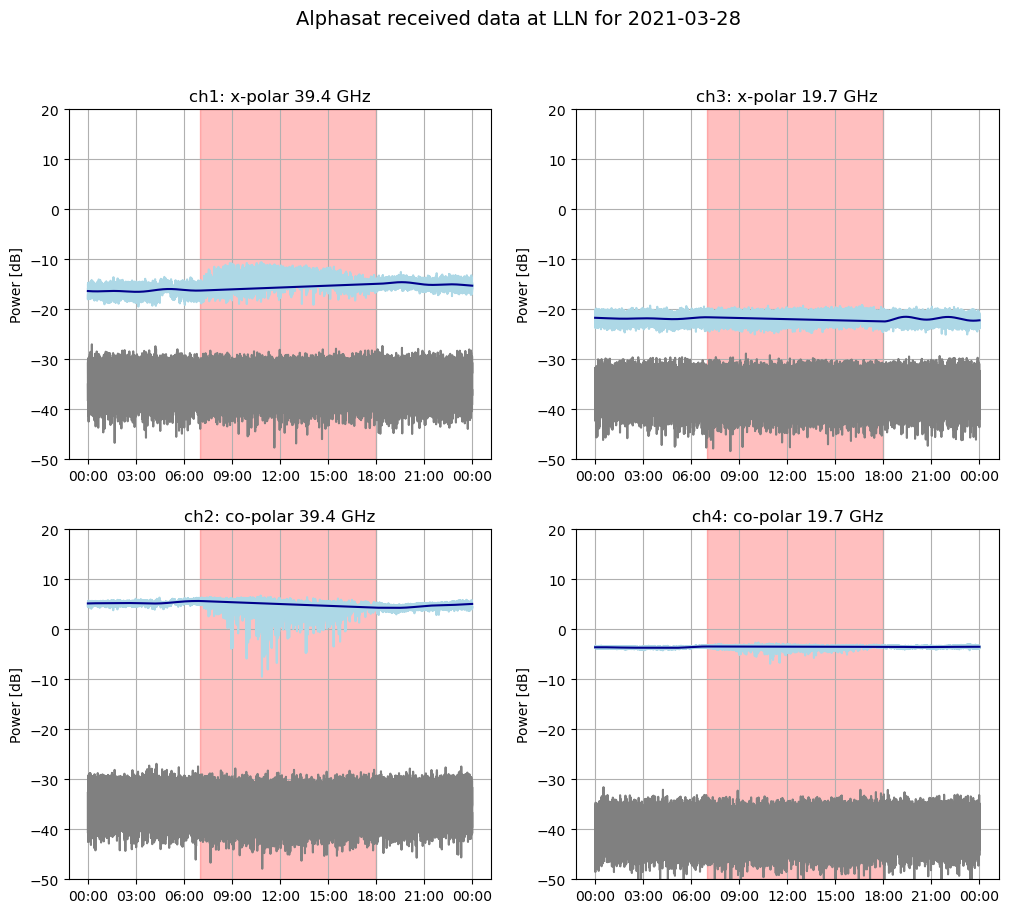

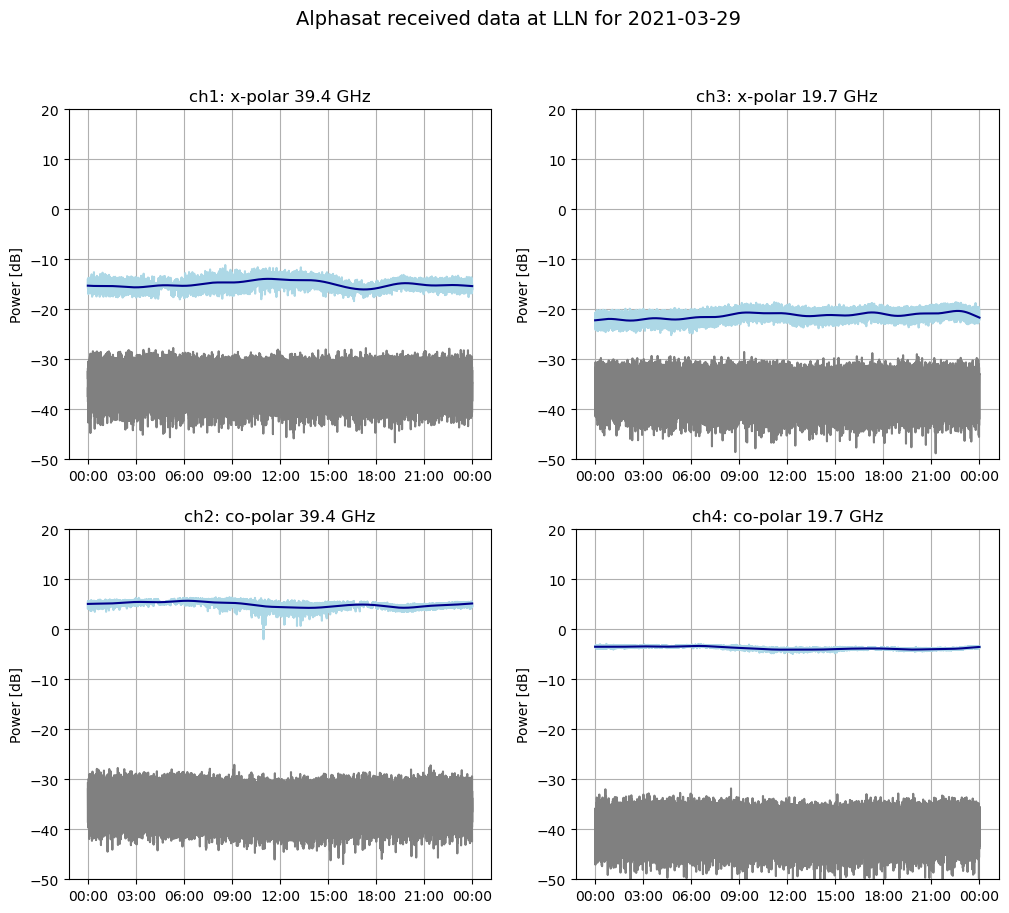

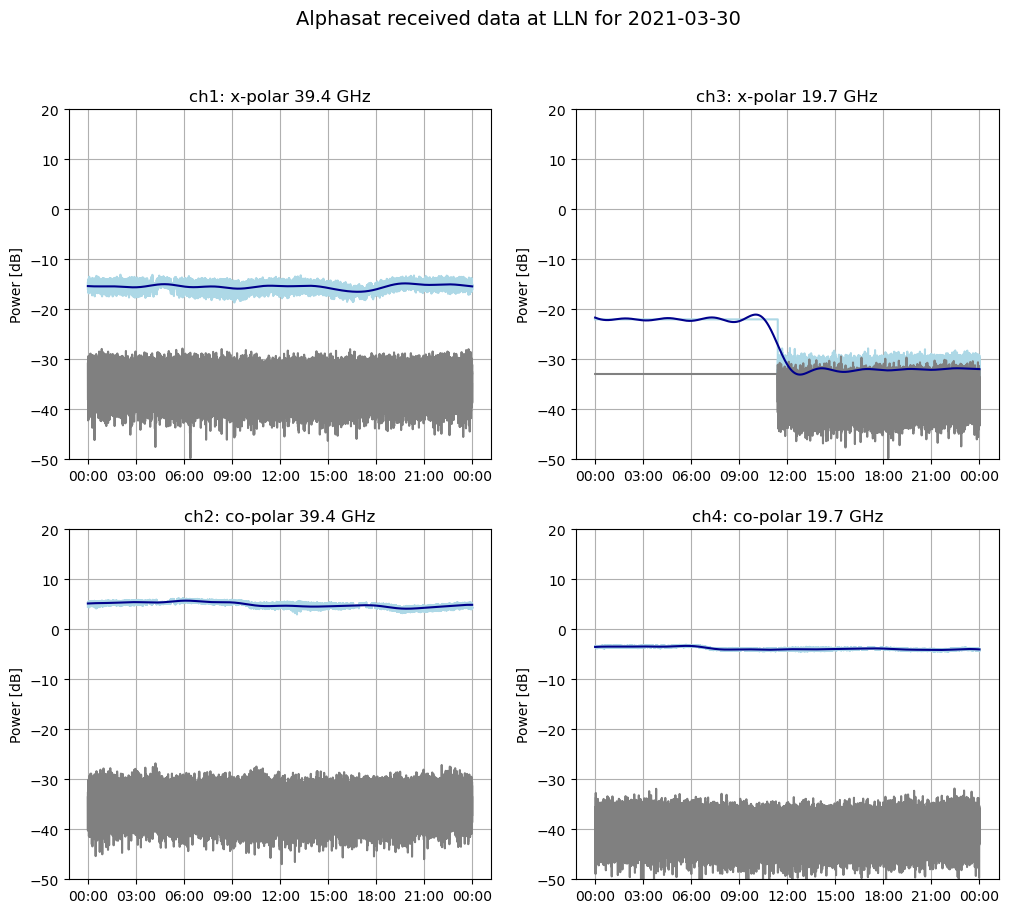

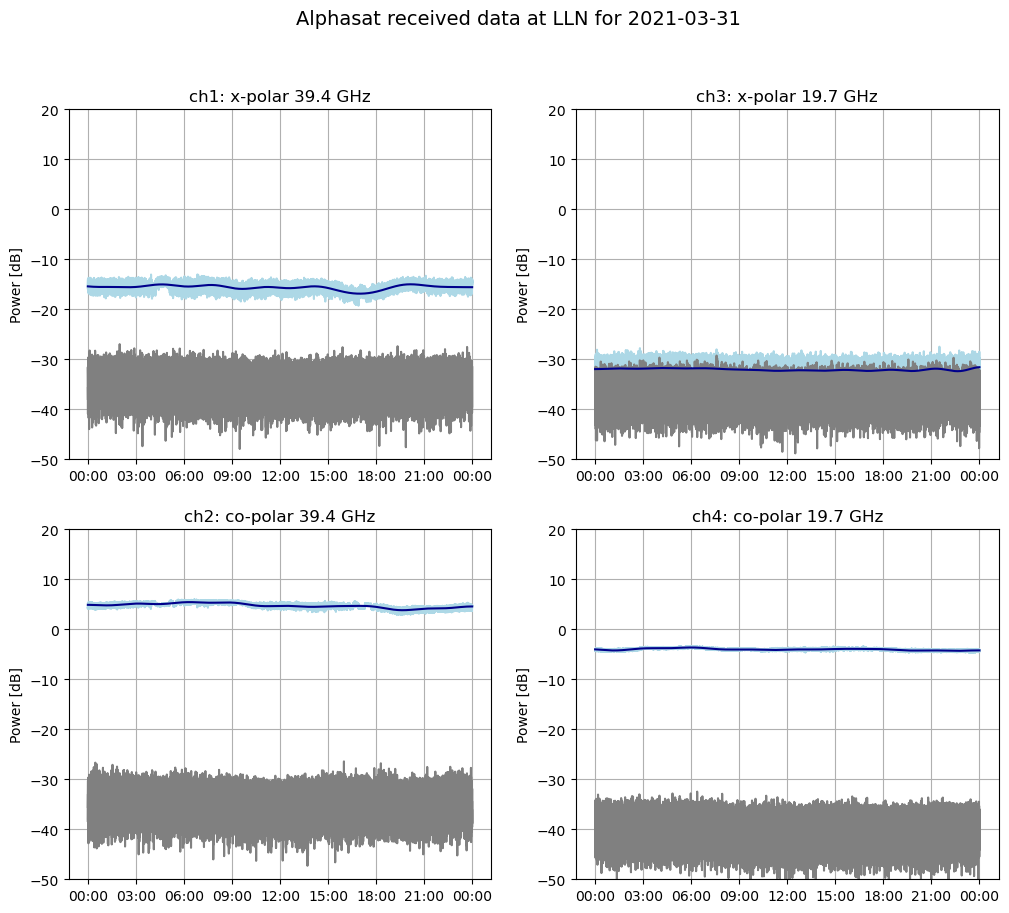

In [21]:
### Plot of the signal and filtered signal + interpolation during rain events 
all_dates = pd.date_range(start='2021-03-28', end='2021-03-31')

for date in all_dates:
    utils.plot_one_day_4ch(date, df_ch1, df_ch2, df_ch3, df_ch4, signal_filt=True, bool_save=True, show=True)


In [34]:
for ch in (df_ch1, df_ch2, df_ch3, df_ch4):
    ch.loc[:, 'excess_attenuation'] = ch.loc[:, 'signal'] - ch.loc[:, 'signal_filt']

c:\Users\gauti\OneDrive - UCL\Documents\UCL - EPL\Master\Master 1 Q1\LELEC2910\Propagation Project\Notebooks\utils.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[:, 'flag'][0] == 1: #if rain at the start of the day
c:\Users\gauti\OneDrive - UCL\Documents\UCL - EPL\Master\Master 1 Q1\LELEC2910\Propagation Project\Notebooks\utils.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.loc[:, 'flag'][-1] == 1: #if rain at the end of the day


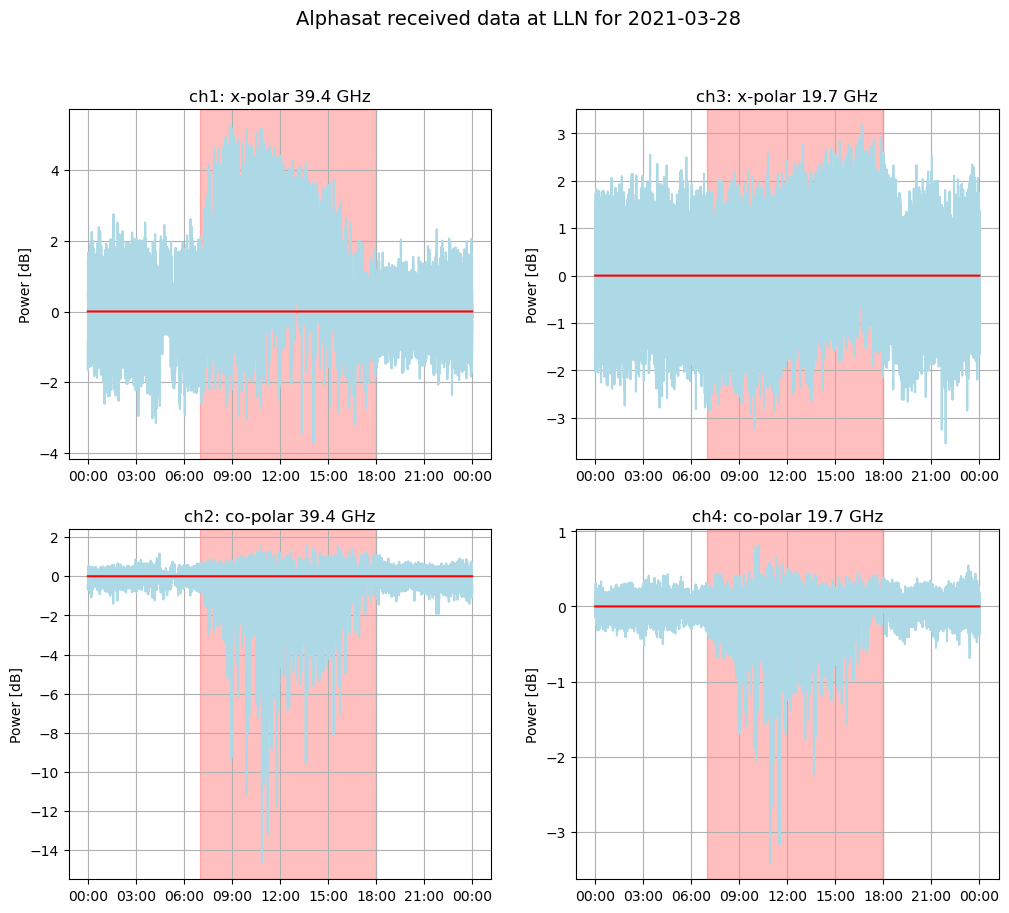

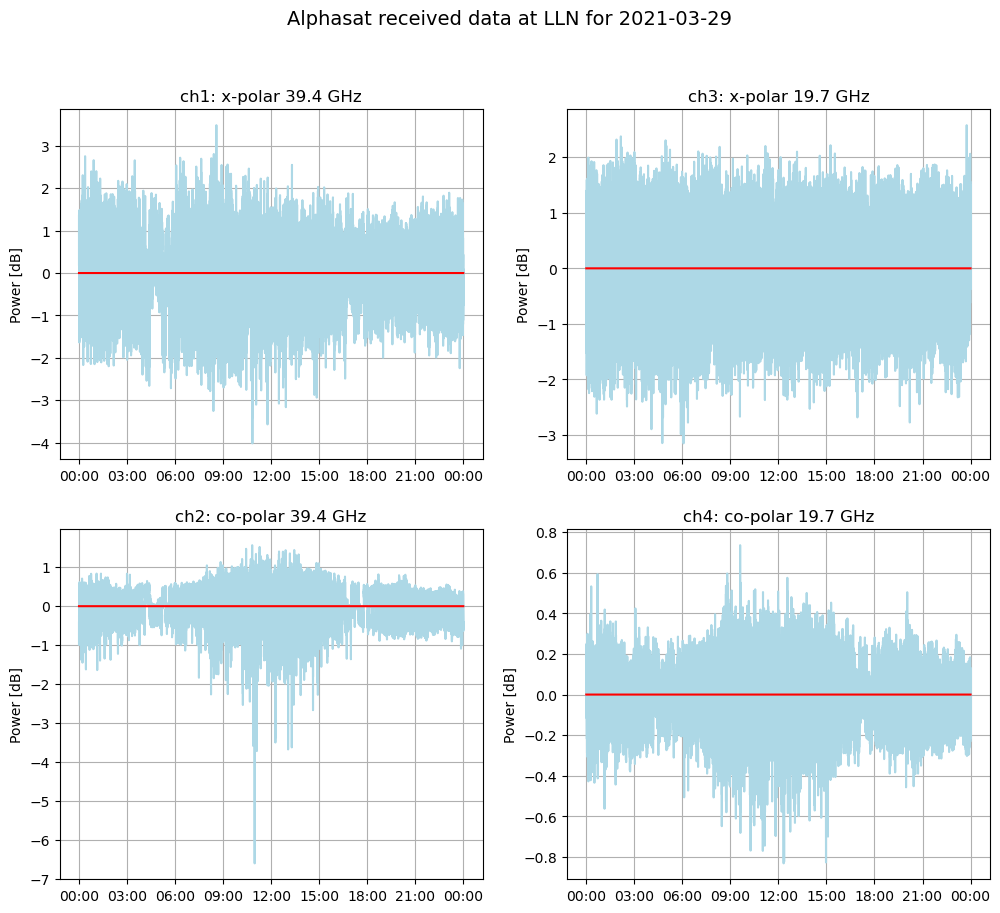

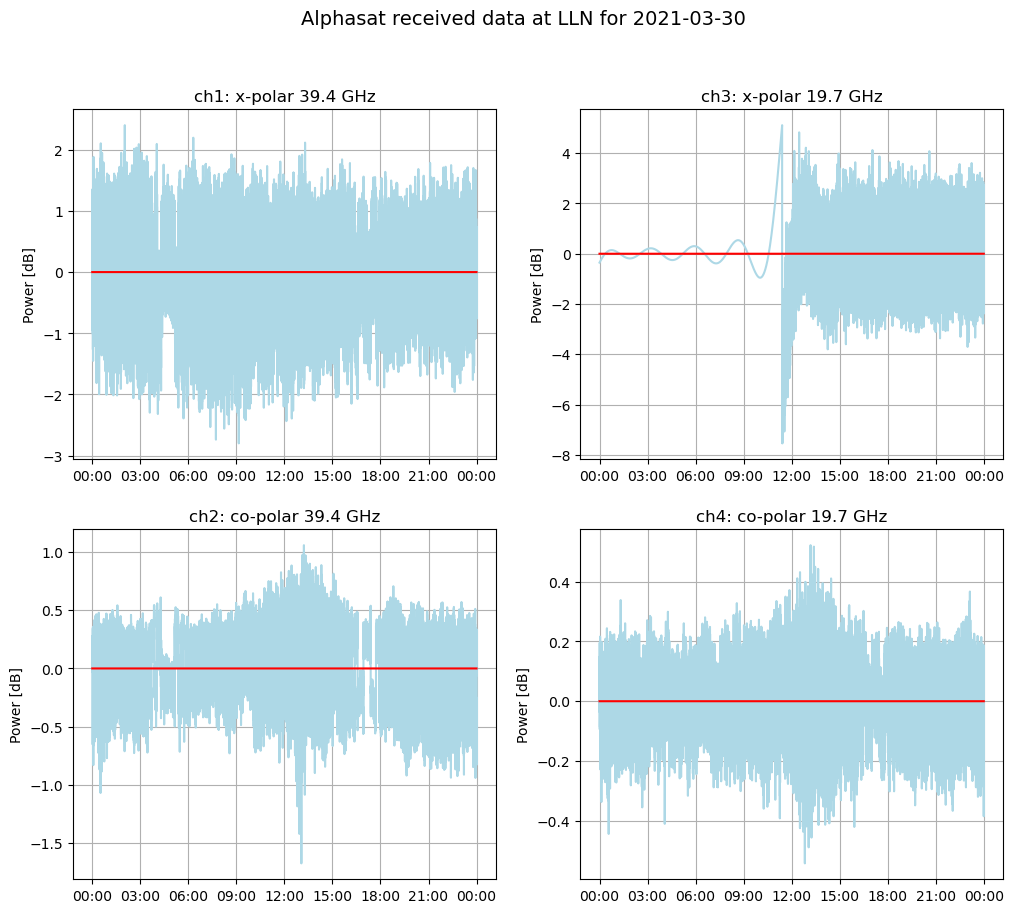

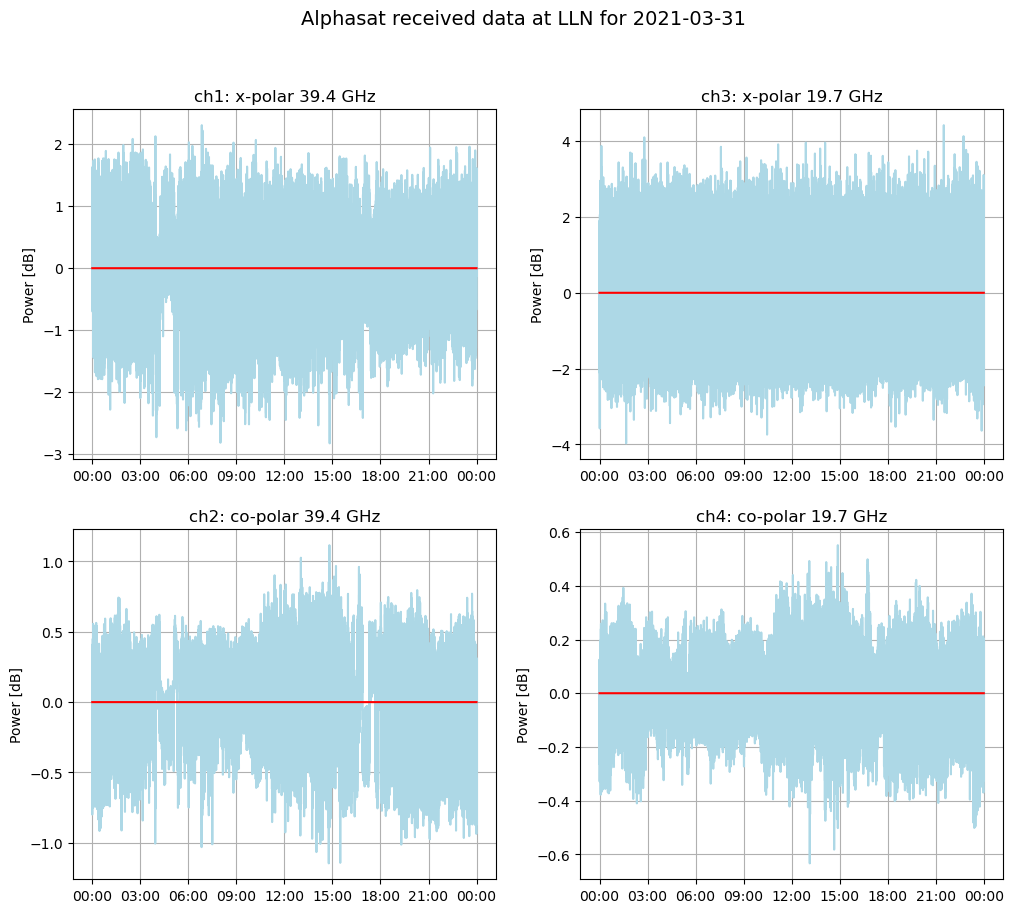

In [35]:
### Plot of the signal excess attenuation

# all_dates = pd.date_range(start='2021-03-01', end='2021-03-31')

for date in all_dates:
    utils.plot_one_day_4ch(date, df_ch1, df_ch2, df_ch3, df_ch4, excess_attenuation=True, bool_save=True, show=True)


## 4) Comparison with RAPIDS outputs
The cell below loads RAPIDS simulation outputs at LLN for the 19.7GHz-frequency, and is given as an example. Only the total attenuation and the rain attenuation are loaded. Per frequency, two files are needed (one file is for the elevation angles $\theta = 5°,10°,...,50°$ and the other is for $\theta=55°,...,90°$). Plots are given as examples, and should compare with the graphs generated automatically by the RAPIDS software (available in the output files).

In [ ]:
### Total attenuation at 19.7 GHz
field_names = ["SITE","SATELLITE","FREQUENCY","ELEVATION","EP","PROBABILITY","ATTENUATION"] #for total attenuation

file1 = pd.read_csv("rapids/lln_19GHz_1/output/ascii/attenuation_total.csv",skiprows=7,names=field_names)
file2 = pd.read_csv("rapids/lln_19GHz_2/output/ascii/attenuation_total.csv",skiprows=7,names=field_names)
rapids_total_attenuation = pd.concat((file1,file2))

print(rapids_total_attenuation)
utils.plot_RAPIDS_outputs(rapids_total_attenuation,"Total attenuation for LLN at 19.7 GHz")


### Rain attenuation at 19.7 GHz
field_names = ["SITE","SATELLITE","FREQUENCY","ELEVATION","ELEVATION_PROBABILITY","PROBABILITY","HR","R001","K","ALPHA","ATTENUATION"] #for rain

file1 = pd.read_csv("rapids/lln_19GHz_1/output/ascii/attenuation_rain.csv",skiprows=7,names=field_names)
file2 = pd.read_csv("rapids/lln_19GHz_2/output/ascii/attenuation_rain.csv",skiprows=7,names=field_names)
rapids_rain_attenuation = pd.concat((file1,file2))

print(rapids_rain_attenuation)
utils.plot_RAPIDS_outputs(rapids_rain_attenuation,"Rain attenuation for LLN at 19.7 GHz")


At this point, you should be able to compare your measured statistics with the ones from RAPIDS, knowing the elevation angle of the Alphasat satellite as seen from Louvain-la-Neuve (see slides of the project introduction session).

In [ ]:
# ...